### 1. Problem Definition

How well can we predict the store sales on data from Corporación Favorita?

### 2.Data 

The data is downloaded from : https://www.kaggle.com/competitions/store-sales-time-series-forecasting

- train.csv:
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
- test.csv:
The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.
sample_submission.csv
A sample submission file in the correct format.
- stores.csv:
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.
- oil.csv:
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
- holidays_events.csv:
Holidays and Events, with metadata

### 3. Evaluation

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.


### 4. Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from warnings import simplefilter
simplefilter("ignore")

In [3]:
# import piplite
# await piplite.install('seaborn') 
import seaborn as sns

In [4]:
# oil= pd.read_csv('oil.csv',parse_dates =["date"])
# stores= pd.read_csv('stores.csv')
# holidays = pd.read_csv('holidays_events.csv',parse_dates =["date"])
# transactions = pd.read_csv('transactions_sample.csv',parse_dates =["date"])
# train = pd.read_csv('train_sample.csv',parse_dates =["date"])
oil= pd.read_csv('/users/jihyeson/ds-project-data/oil.csv',parse_dates =["date"])
stores= pd.read_csv('/users/jihyeson/ds-project-data/stores.csv')
holidays = pd.read_csv('/users/jihyeson/ds-project-data/holidays_events.csv',parse_dates =["date"])
transactions = pd.read_csv('/users/jihyeson/ds-project-data/transactions.csv',parse_dates =["date"])
train = pd.read_csv('/users/jihyeson/ds-project-data/train.csv',parse_dates =["date"])

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


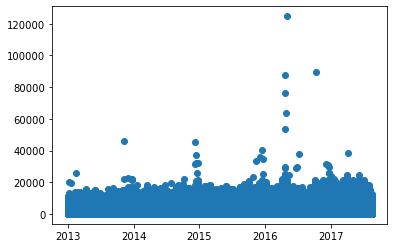

In [30]:
fig, ax =plt.subplots()
ax.scatter(train['date'],y=train['sales'])

In [5]:
oil  = oil.set_index("date").to_period()
oil.head(3)

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97


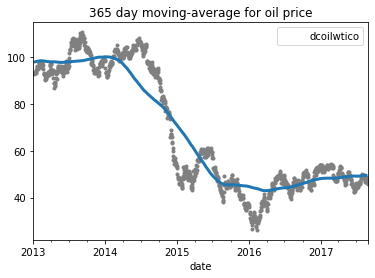

In [6]:
moving_average = oil.rolling(window=365, center=True, min_periods =183,).mean()
ax = oil.plot(style=".",color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="365 day moving-average for oil price", legend=False);

In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [8]:
oil.dropna(inplace=True)

In [9]:
dp = DeterministicProcess( index = oil.index, constant = True, order =1, drop = True)
X = dp.in_sample()
X.tail()

,const,trend
date,,
2017-08-25,1.0,1171.0
2017-08-28,1.0,1172.0
2017-08-29,1.0,1173.0
2017-08-30,1.0,1174.0
2017-08-31,1.0,1175.0


In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
y = oil["dcoilwtico"]

In [12]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y)

LinearRegression(fit_intercept=False)

In [13]:
y_pred = pd.Series(model.predict(X), index=X.index)

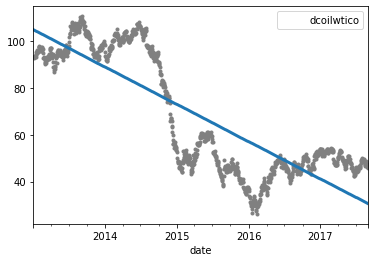

In [14]:
ax = oil.plot(style=".",color="0.5")
y_pred.plot(ax=ax, linewidth=3, label="Trend");

In [15]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

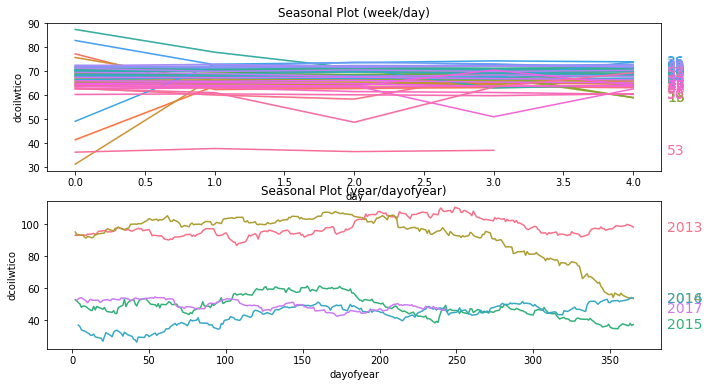

In [16]:
X = oil.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0,ax1) =plt.subplots(2,1,figsize=(11,6))
seasonal_plot(X,y = "dcoilwtico", period ="week", freq="day",ax=ax0)
seasonal_plot(X,y = "dcoilwtico", period ="year", freq="dayofyear",ax=ax1);

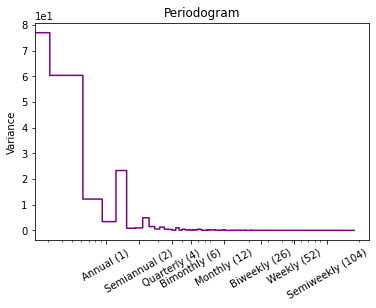

In [17]:
plot_periodogram(oil.dcoilwtico);

In [18]:
transactions.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [19]:
train.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [20]:
train_s = train.groupby(['date','store_nbr']).sum().sales

In [21]:
transactions_merged = pd.merge(transactions,train_s,on=['date','store_nbr'],how='outer')
transactions_merged.head(3)

,date,store_nbr,transactions,sales
0,2013-01-01,25,770.0,2511.618999
1,2013-01-02,1,2111.0,7417.148000
2,2013-01-02,2,2358.0,10266.718981


''

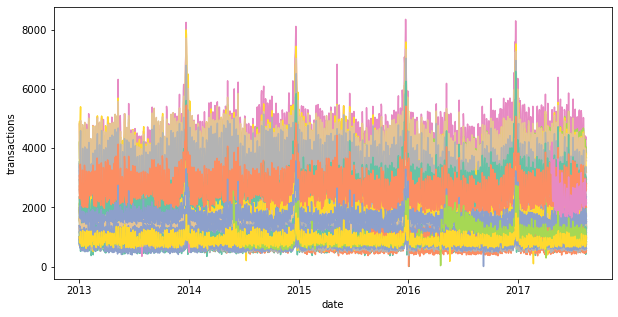

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x="date",y="transactions",hue="store_nbr",palette = "Set2",legend =False,data=transactions_merged)
;

In [23]:
# fig, ax = plt.subplots(figsize=(10,5))
# sns.lineplot(x="date",y="sales",hue="store_nbr",palette = "husl",legend =False,data=transactions_merged);

In [24]:
temp =transactions_merged.groupby('date').sum().drop("store_nbr",axis=1)
temp

,transactions,sales
date,,
2013-01-01,770.0,2511.618999
2013-01-02,93215.0,496092.417944
2013-01-03,78504.0,361461.231124
2013-01-04,78494.0,354459.677093
2013-01-05,93573.0,477350.121229
...,...,...
2017-08-11,89551.0,826373.722022
2017-08-12,89927.0,792630.535079
2017-08-13,85993.0,865639.677471


In [25]:
from sklearn.model_selection import train_test_split

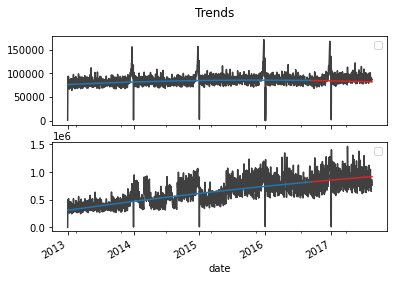

In [26]:
y = temp.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")